**Training a Network with tf.functions**

In [1]:
# importing required libraries and packages, which will be used through code.
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
# this part downloads the cat vs dog dataset from the google servers, and extracts them. finally, you will have train and validation data paths in two variables.
URL =     'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

PATH =          os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir                    =  "/root/.keras/datasets/cats_and_dogs_filtered/train"
validation_dir           = "/root/.keras/datasets/cats_and_dogs_filtered/validation"

68616192/68606236 [==============================] - 2s 0us/step


In [3]:
# first, we have defined the augmentation function with some tf.image attributes.
def augment_data(image):
    image = tf.image.resize_with_crop_or_pad(image, 150, 150)
    image = tf.image.random_brightness(image, 0.5) 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down   (image)
    return image

In [4]:
# Determining class names, will be used in the following function
#Class_Names=['cats','dogs']

In [5]:
# Here, we have defined the get_label function, which assigns a one-hot coded label to each file-path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the     class-directory
  return parts[-2] == 'dogs'         #Class_Names

In [6]:
# a test on above-mentioned function
get_label("/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.0.jpg").numpy()

False

In [7]:
# Next, we'll define a function to load an image, decode it, and change its tensor type to float 32.
def load_img(image_path):
    img = tf.io.read_file(image_path)
    
    # https://stackoverflow.com/questions/44942729/tensorflowvalueerror-images-contains-no-shape
    img = tf.image.decode_image(img, 3, expand_animations=False)
    
    img = tf.cast(img, tf.float32)
    return img

In [8]:
# A function to normalize the images between [0, 1]
def normalize(image):
    image =  (image / 255)
    return image

In [9]:
# Here, the resizing function have been defined, which resizes to an arbitrary size given as input.
def resize(image,height, width):
    image = tf.image.resize(image, (height, width),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #image = tf.image.resize_with_crop_or_pad(image, height, width)
    return image

In [10]:
# a function, which returns image and its label, using load_img and get_label functions,
# corresponding to the given image_path.
def load_image_with_label(image_path):
    label = get_label(image_path)
    img   =  load_img(image_path)
    return img, label

In [11]:
# a Function to load train data, which includes load_image_with_label, augment_data, and normalize functions
def load_image_train(image_file):
    image, label = load_image_with_label(image_file)
    image = augment_data(image)
    image =    normalize(image)
    
    return image, label

In [12]:
# a Function to load test data, which is similar to the previous one, but obviously doesn't include augment_data
def load_image_test(image_file):
    image, label = load_image_with_label(image_file)
    image = resize(image, 150, 150)
    image = normalize(image)

    return image, label

In [13]:
# Determining batch-size and shuffle buffer size, which will be used further.
BATCH_SIZE            = 32
SHUFFLE_BUFFER_SIZE = 500

In [14]:
# extracting train and validation directories from corresponding paths.
train_dir      =             pathlib.Path(train_dir)
validation_dir =        pathlib.Path(validation_dir)

In [15]:
# training and validation datasets are stored in two ShuffleDataset typed files.
train_dataset     = tf.data.Dataset.list_files     (str(train_dir/'*/*'))
validation_dataset= tf.data.Dataset.list_files(str(validation_dir/'*/*'))

In [16]:
print(len(list(train_dataset))     )
print(len(list(validation_dataset)))

2000
1000


In [17]:
# we will use AUTOTUNE in order to employ prefetch attribute for accelleration.
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
# Get train data set
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.    batch(BATCH_SIZE)
train_dataset = train_dataset.   prefetch(AUTOTUNE)

In [19]:
# Get validation data set
validation_dataset = validation_dataset.map(load_image_test)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.cache()

In [20]:
# Determinig and compiling a sequential network model 
from keras import layers
from keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu') )
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [22]:
# Finally, it's training time
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 27s 142ms/step - loss: 0.6932 - acc: 0.5170 - val_loss: 0.6908 - val_acc: 0.5070
Epoch 2/100
63/63 [==============================] - 9s 108ms/step - loss: 0.6813 - acc: 0.5635 - val_loss: 0.6902 - val_acc: 0.5400
Epoch 3/100
63/63 [==============================] - 9s 111ms/step - loss: 0.6745 - acc: 0.5900 - val_loss: 0.6852 - val_acc: 0.5790
Epoch 4/100
63/63 [==============================] - 10s 112ms/step - loss: 0.6639 - acc: 0.5985 - val_loss: 0.8021 - val_acc: 0.5050
Epoch 5/100
63/63 [==============================] - 9s 112ms/step - loss: 0.6657 - acc: 0.5950 - val_loss: 0.6974 - val_acc: 0.5710
Epoch 6/100
63/63 [==============================] - 9s 119ms/step - loss: 0.6608 - acc: 0.6150 - val_loss: 0.7047 - val_acc: 0.5550
Epoch 7/100
63/63 [==============================] - 9s 110ms/step - loss: 0.6493 - acc: 0.6375 - val_loss: 0.6998 - val_acc: 0.5670
Epoch 8/100
63/63 [==============================] - 9s 113ms/step 

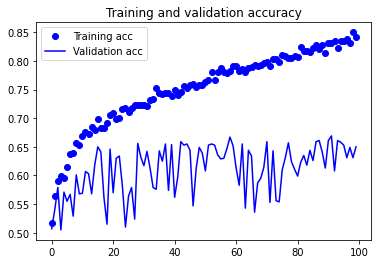

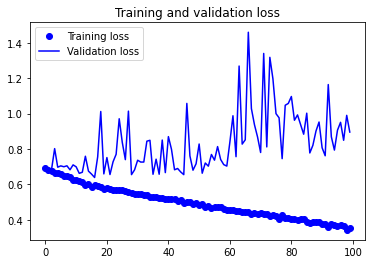

In [23]:
acc  = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss= history.history['val_loss']

epochs  = range(len(acc))

plt.plot(epochs, acc, 'bo'     , label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title          ('Training and validation loss')
plt.legend()

plt.show()